### Note: As of time of writing, analysis is being performed on incomplete dataset for pedagogical purposes. In other words, the plots below are not informative of the information presented in the original manuscript.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat, read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = read_csv('data/moodRL_data.csv')
metadata = read_csv('data/moodRL_metadata.csv')
ratings = read_csv('data/moodRL_ratings.csv')

## Section 1: Sanity Checks

### Task performance
Screen participants for number of optimal choices. 

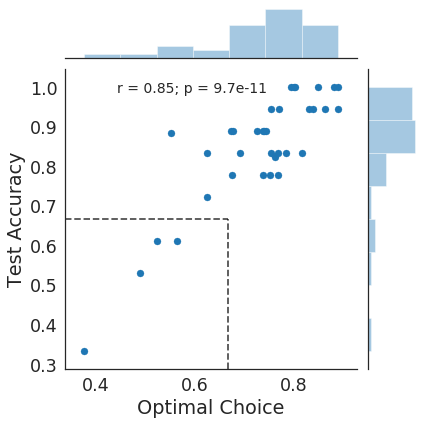

In [2]:
from scipy.stats import binom

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Rejection parameters.
n_test_trials = 18
chance = 0.50
alpha = 0.1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Optimal choices.
ix = np.logical_and(data.Block<4, data.Choice.notnull())
optimal_choice = data[ix].copy()
optimal_choice['Optimal'] = np.equal(optimal_choice['Choice'], 
                                     optimal_choice[['M1','M2']].max(axis=1))
optimal_choice = optimal_choice.groupby('Datetime').Optimal.mean().reset_index()

## Discrimination check.
ix = np.logical_and(data.Block==4, data.Choice.notnull())
discrimination = data[ix].copy()
discrimination[['M1','M2','Choice']] = np.where(discrimination[['M1','M2','Choice']] % 3, 
                                                discrimination[['M1','M2','Choice']] % 3, 3)
discrimination = discrimination[~np.equal(discrimination['M1'],discrimination['M2'])]
discrimination['Optimal'] = np.equal(discrimination['Choice'], 
                                     discrimination[['M1','M2']].max(axis=1))
discrimination = discrimination.groupby('Datetime').Optimal.mean().reset_index()

## Merge.
gb = optimal_choice.merge(discrimination, on='Datetime')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Reject participants.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define rejection level.
reject_level = binom.ppf(1-alpha, n_test_trials, chance) / n_test_trials

## Identify participants beneath threshold.
reject_id = gb.loc[gb.Optimal_y < reject_level, 'Datetime']

## Remove.
data = data[~np.in1d(data.Datetime, reject_id)]
metadata = metadata[~np.in1d(metadata.Datetime, reject_id)]
ratings = ratings[~np.in1d(ratings.Datetime, reject_id)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot.
g = sns.jointplot('Optimal_x', 'Optimal_y', data=gb,  annot_kws=dict(stat="r", fontsize=14),
                  marginal_kws=dict(hist_kws=dict(edgecolor='w', linewidth=1)))
g.set_axis_labels(xlabel='Optimal Choice', ylabel='Test Accuracy')

## Plot rejection levels.
xmin, xmax = g.fig.axes[0].get_xlim()
ymin, ymax = g.fig.axes[0].get_ylim()
g.fig.axes[0].hlines(reject_level, xmin, reject_level, linestyle='--', alpha=0.7)
g.fig.axes[0].vlines(reject_level, ymin, reject_level, linestyle='--', alpha=0.7)
g.fig.axes[0].set(xlim=(xmin,xmax), ylim=(ymin,ymax))

plt.tight_layout()

### Task Learning

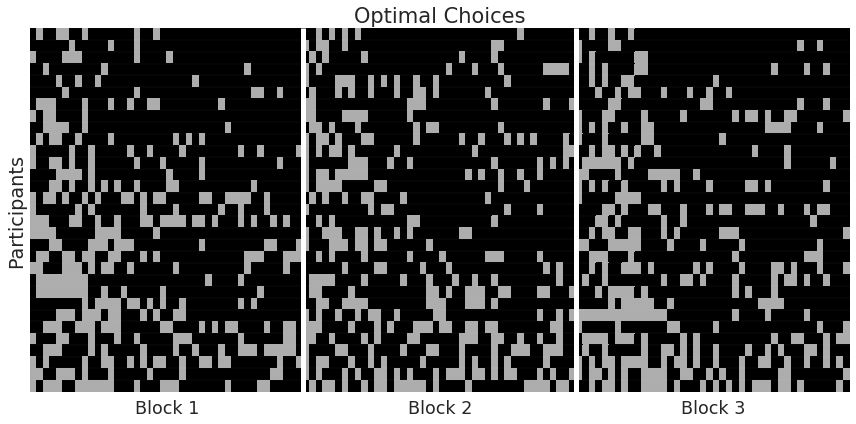

In [3]:
from matplotlib.colors import ListedColormap

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Optimal choices.
optimal_choice = data[data.Block<4].copy()
optimal_choice['Optimal'] = np.equal(optimal_choice['Choice'], 
                                     optimal_choice[['M1','M2']].max(axis=1))

## Define metadata.
n_subjects = optimal_choice.Datetime.unique().size
n_trials = optimal_choice.Trial.max()
n_blocks = optimal_choice.Block.max()

optimal_choice = optimal_choice.Optimal.values.reshape(n_subjects, n_blocks*n_trials).astype(int)

## Sort.
sort_ix = np.argsort(optimal_choice.mean(axis=-1))
optimal_choice = optimal_choice[sort_ix[::-1]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,6))
cmap = ListedColormap(['#adadad','k'])

## Plot.
sns.heatmap(optimal_choice, cmap=cmap, cbar=False)

## Add info.
ax.vlines(np.arange(1,n_blocks)*n_trials, 0, n_subjects, lw=5, color='w')
ax.hlines(np.arange(n_subjects), 0, n_trials*n_blocks, lw=0.05, color='w')
ax.set(xticks=[21,63,105], yticks=[], ylabel='Participants', title='Optimal Choices')
ax.set_xticklabels(['Block 1', 'Block 2', 'Block 3'], rotation=0)

plt.tight_layout()

### Mood

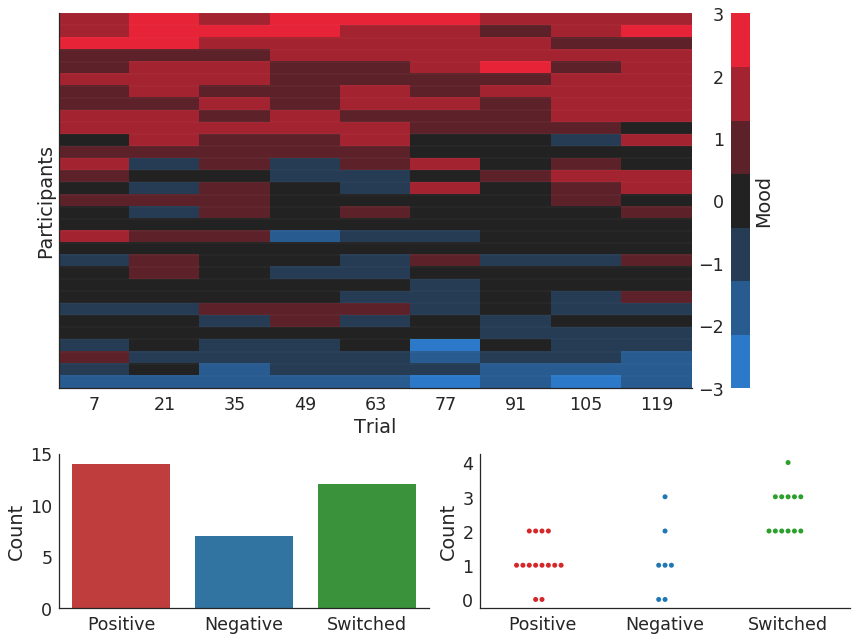

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
mood = ratings[ratings.Variable=='Mood'].copy()

## Define metadata.
n_subjects = mood.Datetime.unique().size
trials = np.unique( (mood.Block-1) * 42 + mood.Trial)
n_trials = trials.size

mood = mood.Rating.values.reshape(n_subjects, n_trials)

## Sort.
sort_ix = np.argsort(mood.mean(axis=-1))
mood = mood[sort_ix[::-1]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Count.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Bin participants.
positive_only = np.all(mood >= 0, axis=-1)
negative_only = np.all(mood <= 0, axis=-1)
switched_sign = np.any(mood > 0, axis=-1) * np.any(mood < 0, axis=-1)

## Compute range.
mood_range = np.ptp(mood, axis=-1)

## Convert to DataFrame.
clusters = DataFrame(dict(Positive = positive_only, 
                          Negative = negative_only,
                          Switched = switched_sign,
                          Range = mood_range))

clusters = clusters.melt(id_vars='Range', var_name='Cluster')
clusters = clusters[clusters.value]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,9))

## Plot.
ax = plt.subplot2grid((3,2),(0,0),colspan=2,rowspan=2)
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=7, center="dark")
sns.heatmap(mood, vmin=-3, vmax=3, cmap=cmap, cbar_kws=dict(label='Mood'), ax=ax)
ax.hlines(np.arange(n_subjects), 0, n_trials, lw=0.05, color='w')
ax.set(xticklabels=trials, xlabel='Trial', yticks=[], ylabel='Participants')

## Plot countplot.
ax = plt.subplot2grid((3,2),(2,0))
palette = ['#d62728', '#1f77b4', '#2ca02c']
sns.countplot('Cluster', data=clusters, order=['Positive','Negative','Switched'],
              palette=palette, ax=ax)
ax.set(yticks=np.linspace(0,15,4), xlabel='', ylabel='Count')

## Plot stripplot.
ax = plt.subplot2grid((3,2),(2,1))
sns.swarmplot('Cluster', 'Range', data=clusters, order=['Positive','Negative','Switched'],
              palette=palette, ax=ax)
ax.set(yticks=np.arange(clusters.Range.max()+1), xlabel='', ylabel='Count')

sns.despine()
plt.tight_layout()

### Subjective estimates of likelihood of win

In [ ]:
g = sns.FacetGrid(ratings[ratings.Variable!='Mood'], col='Block', size=4)
g.map(sns.pointplot, 'Trial', 'Rating', 'Variable', palette=['#4c72b0', '#55a868', '#c44e52'])
g.axes[0,0].set(ylim=(15,65), ylabel='Subjective Estimate');

### Wheel of fortune mood manipulation

In [ ]:

df = ratings.merge(metadata[['Subject','Datetime','WoF']], on=['Subject','Datetime'])
df['Outcome'] = np.where(df.WoF > 0, 'Win', 'Loss')

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot('Block', 'Rating', 'Outcome', data=df[df.Variable=='Mood'], 
            palette=['#4c72b0', '#c44e52'], ax=ax)

## Add info.
ax.set(ylabel='Self-reported feeling')
ax.hlines(0,*ax.get_xlim(),lw=0.5)
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5))

sns.despine()
plt.tight_layout()

## Section 2: Model Fitting
### Choice of priors

In [ ]:
from scipy.stats import norm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prior parameters
mu = 0
sd = 1
scale = 50

## Sampling parameters.
x = np.linspace(-5,5,100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def inv_logit(arr):
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(16,4))

## Compute PDF.
y = norm(mu,sd).pdf(x)

## Plot functions.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', yticks=np.linspace(0,1,3), ylabel='y', title='phi_approx')

## Plot learning rate.
axes[1].plot(phi_approx(x) * scale, y, lw=2.5)
axes[1].set(xlabel=r'%s $\cdot$ phi_approx( $\mathcal{N}(%s, %s)$ )' %(scale,mu,sd), 
            xticks=np.linspace(0,scale,5), ylabel='PDF', 
            title=r'Inverse Temperature ($\beta$)')

## Plot learning rate.
axes[2].plot(phi_approx(x), y, lw=2.5)
axes[2].set(xlabel=r'phi_approx( $\mathcal{N}(%s, %s)$ )' %(mu,sd), 
            ylabel='PDF', title=r'Learning Rate ($\eta$)')

sns.despine()
plt.tight_layout()

### Baseline model: Standard RL (single subject)

In [ ]:
import pystan
from scripts.plotting_utility import plot_toy_model

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subject parameters.
subjects = np.arange(data.Datetime.unique().size)

## RL parameters.
q = 0

## Sampling parameters.
model_name = 'moodRL_toy.stan'
samples = 1000
warmup = 750
chains = 4
thin = 1
n_jobs = 2
   
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Locate stan model.
file = 'stan_models/%s' %model_name
    
for i, subject in enumerate(subjects):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Define subject.
    datetime = data.Datetime.unique()[subject]

    ## Reduce DataFrame.
    df = data[np.logical_and(data.Datetime==datetime, data.Block < 4)].copy()

    ## Drop trials with missing data.
    df = df[df.Choice.notnull()]

    ## Extract and prepare data.
    X = df[['M1','M2']].values
    Y = np.array([ np.argmax(x == y)+1 for x, y in zip(X, df.Choice.values) ])
    R = df.Outcome.values
    B = df.Block.values

    ## Define metadata.
    T = R.size

    ## Organize data dictionary.
    dd = dict(T=T, X=X, Y=Y, R=R, B=B, q=q)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Fit model.
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                      chains=chains, seed=47404, n_jobs=n_jobs)

    ## Plot.
    plot_toy_model('plots/%s/subj%s.png' %(model_name.replace('.stan',''), i), fit)
    
print('Done.')

### Baseline model: Standard RL (hierarchical)

In [ ]:
import pystan, time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Model parameters.
q = 0

## Sampling parameters.
model_name = 'moodRL_base.stan'
samples = 100
warmup = 50
chains = 2
thin = 1
n_jobs = 2
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Reduce DataFrame.
df = data[data.Block < 4].copy()

## Drop trials with missing data.
df = df[df.Choice.notnull()]

## Extract and prepare data.
X = df[['M1','M2']].values
Y = np.array([ np.argmax(x == y)+1 for x, y in zip(X, df.Choice.values) ])
R = df.Outcome.values

## Define metadata.
_, ix = np.unique(df.Datetime, return_inverse=True)
ix += 1
T = ix.size
N = ix.max()

## Organize data dictionary.
dd = dict(T=T, N=N, ix=ix, X=X, Y=Y, R=R, q=q)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model fitting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
print('n_samples = %0.0f.' %((samples - warmup) * chains / thin), end=' ')

file = 'stan_models/%s' %model_name
st = time.time()
fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                  chains=chains, seed=47404, n_jobs=n_jobs)
print('Elapsed time: %0.2f s.' %(time.time()-st), end='\n\n')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract results.
parameters = fit.extract()